In [20]:
%matplotlib inline
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

DATASET_PATH = '../data/augmented/'

In [21]:
files = os.listdir(DATASET_PATH)

rawx=[]
rawy=[]
for file in files:
    img = cv2.imread(os.path.join(DATASET_PATH,file),cv2.IMREAD_GRAYSCALE)
    rawx.append(img)
    rawy.append(int(file.split('_')[1]))

In [22]:
im_h, im_w = rawx[0].shape
num_classes = len(np.unique(rawy))

In [23]:
x = np.asarray(rawx)
y = np.asarray(rawy)
x = x.reshape(len(files),im_h,im_w,1)
print(x.shape)
print(y.shape)

(600, 200, 200, 1)
(600,)


In [24]:
rawx= None
rawy= None

In [25]:
x = x / 255.

In [26]:
np.unique(y)

array([0, 1, 2, 3, 4, 5])

In [27]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.2,stratify=y)

In [28]:
x = None
y = None

In [29]:
def plot_6_images(xt,yt):
    
    idxs = [ random.randint(0,len(xt)) for i in range(0,6)]
    plt.figure(figsize=(10,5))
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.imshow(xt[idxs[i]].reshape(im_w,im_h),cmap='gray')
        plt.title('y={}'.format(yt[idxs[i]]))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()  

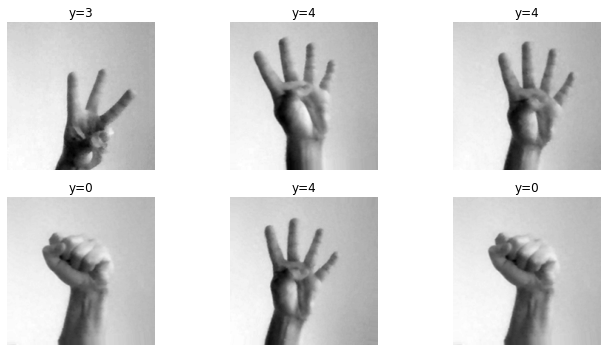

In [30]:
plot_6_images(xtrain,ytrain)

In [31]:
from keras.backend import clear_session

clear_session()
model = None

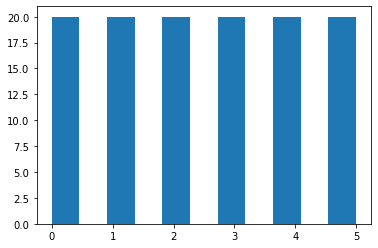

In [32]:
from keras.utils import to_categorical

ytrain_cat = to_categorical(ytrain, num_classes)
ytest_cat = to_categorical(ytest, num_classes)

plt.hist(ytest,bins=11);

In [33]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.losses import categorical_crossentropy
from keras.optimizers import SGD, Adam, Adadelta
from keras.metrics import categorical_accuracy

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',padding='valid', input_shape=(im_w,im_h,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3),padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3),padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.125))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=categorical_crossentropy,
              optimizer=Adadelta(),
              metrics=[categorical_accuracy])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 198, 198, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 46, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 23, 23, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 128)      

In [36]:
# import tensorflow as tf
EPOC = 25
BS = 64

history = model.fit(xtrain, ytrain_cat, validation_split=0.2, batch_size=BS, epochs=EPOC)


Train on 384 samples, validate on 96 samples
Epoch 1/50
384/384 [==============================] - 2s 4ms/step - loss: 1.7759 - categorical_accuracy: 0.2109 - val_loss: 2.0771 - val_categorical_accuracy: 0.2604
Epoch 2/50
384/384 [==============================] - 2s 4ms/step - loss: 1.7996 - categorical_accuracy: 0.2500 - val_loss: 1.7634 - val_categorical_accuracy: 0.1979
Epoch 3/50
384/384 [==============================] - 2s 4ms/step - loss: 1.7124 - categorical_accuracy: 0.2578 - val_loss: 1.6463 - val_categorical_accuracy: 0.4167
Epoch 4/50
384/384 [==============================] - 2s 4ms/step - loss: 1.5677 - categorical_accuracy: 0.3880 - val_loss: 1.6806 - val_categorical_accuracy: 0.3125
Epoch 5/50
384/384 [==============================] - 2s 4ms/step - loss: 1.5720 - categorical_accuracy: 0.3307 - val_loss: 3.1472 - val_categorical_accuracy: 0.2917
Epoch 6/50
384/384 [==============================] - 2s 4ms/step - loss: 2.0276 - categorical_accuracy: 0.2552 - val_loss: 2

In [37]:
history.params

{'batch_size': 64,
 'epochs': 50,
 'steps': None,
 'samples': 384,
 'verbose': 1,
 'do_validation': True,
 'metrics': ['loss',
  'categorical_accuracy',
  'val_loss',
  'val_categorical_accuracy']}

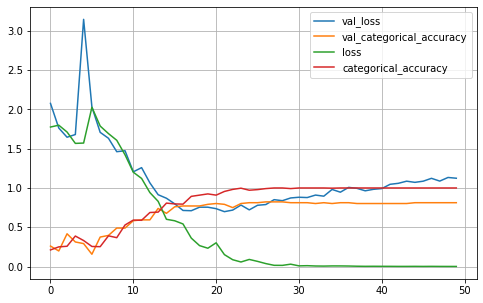

In [38]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca()
plt.show()

In [39]:
model.evaluate(xtest, ytest_cat)

120/120 [==============================] - 1s 4ms/step


[0.8010703206062317, 0.8416666388511658]

In [40]:
import pandas as pd
ypred = model.predict_classes(xtest)

pd.crosstab(ytest, ypred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,2,3,4,5,All
True,,,,,,,
0,15,0,2,2,1,0,20
1,1,16,1,0,0,2,20
2,1,1,17,0,0,1,20
3,0,0,2,17,1,0,20
4,0,0,0,1,18,1,20
5,0,0,0,0,2,18,20
All,17,17,22,20,22,22,120


In [41]:
model.save('model_cnn.h5')

In [42]:
from keras.models import load_model
mymodel = load_model('model_cnn.h5')

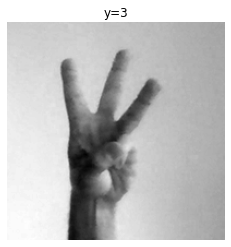

In [82]:
files = os.listdir('../data/originals/')
idx = random.randint(0,len(files))
origimg = cv2.imread('../data/originals/'+files[idx],cv2.IMREAD_GRAYSCALE)

myimg = origimg/255.
myimg = cv2.resize(myimg,(im_h, im_w))
myimg = myimg.reshape(1,im_h, im_w,1)

myclass = mymodel.predict(myimg)
pred = np.argmax(myclass)

plt.imshow(origimg, cmap='gray');
plt.title('y=%d' % pred);
plt.axis('off');
